# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Jingwei Hu, Tianru Zhang, David Vävinggren

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Fill in</font>

- **Team ID:** <font color='red'>Fill in</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/54581/assignments

**Due Date:** August 22, 2025.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [1]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [2]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [3]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [4]:
# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

codesubset.tar.gz already exits. Using cached. Delete it manually to recieve it again!


In [5]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

codesubset already exits. Using cached. Delete it manually to recieve it again!


Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [6]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/paulhausner/ecg-preprocessing.git

ecg-preprocessing already exits. Using cached. Delete it manually to recieve it again!


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

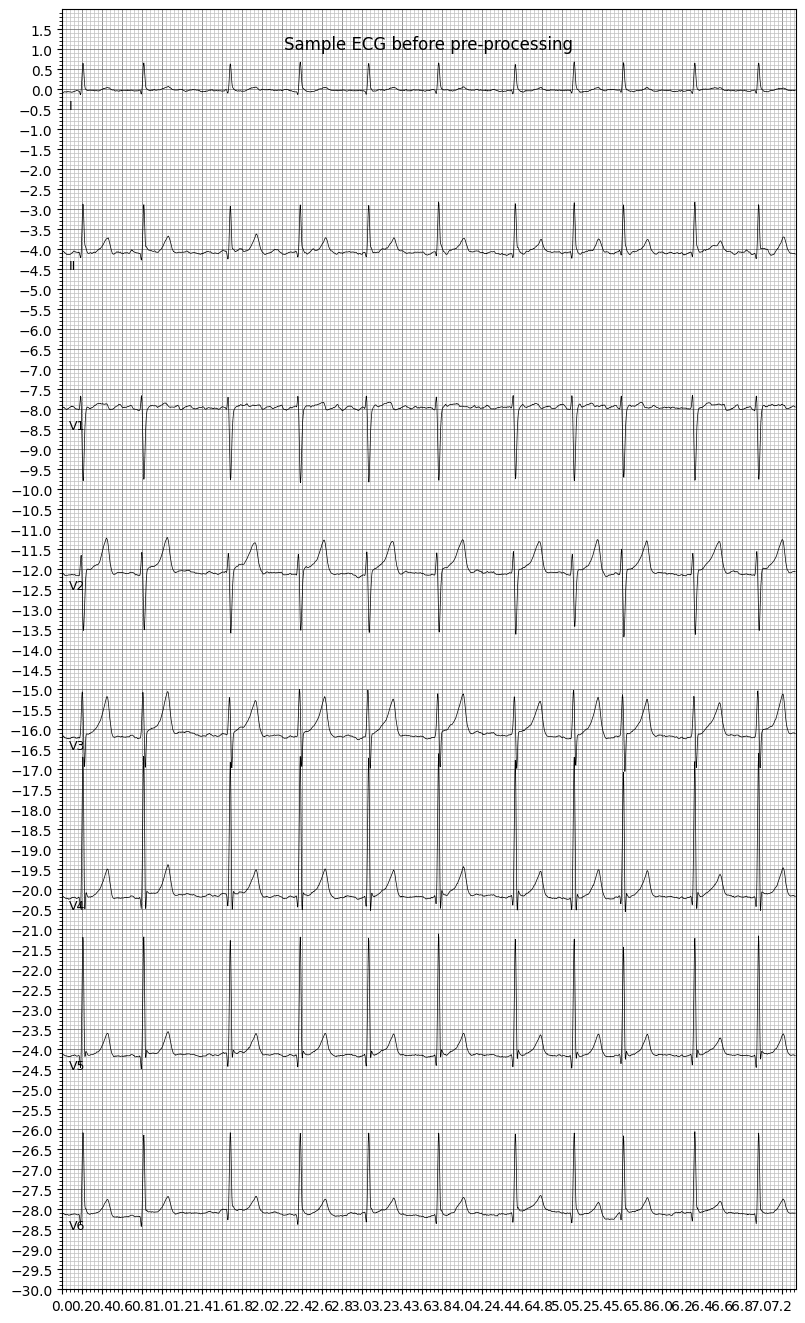

In [7]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

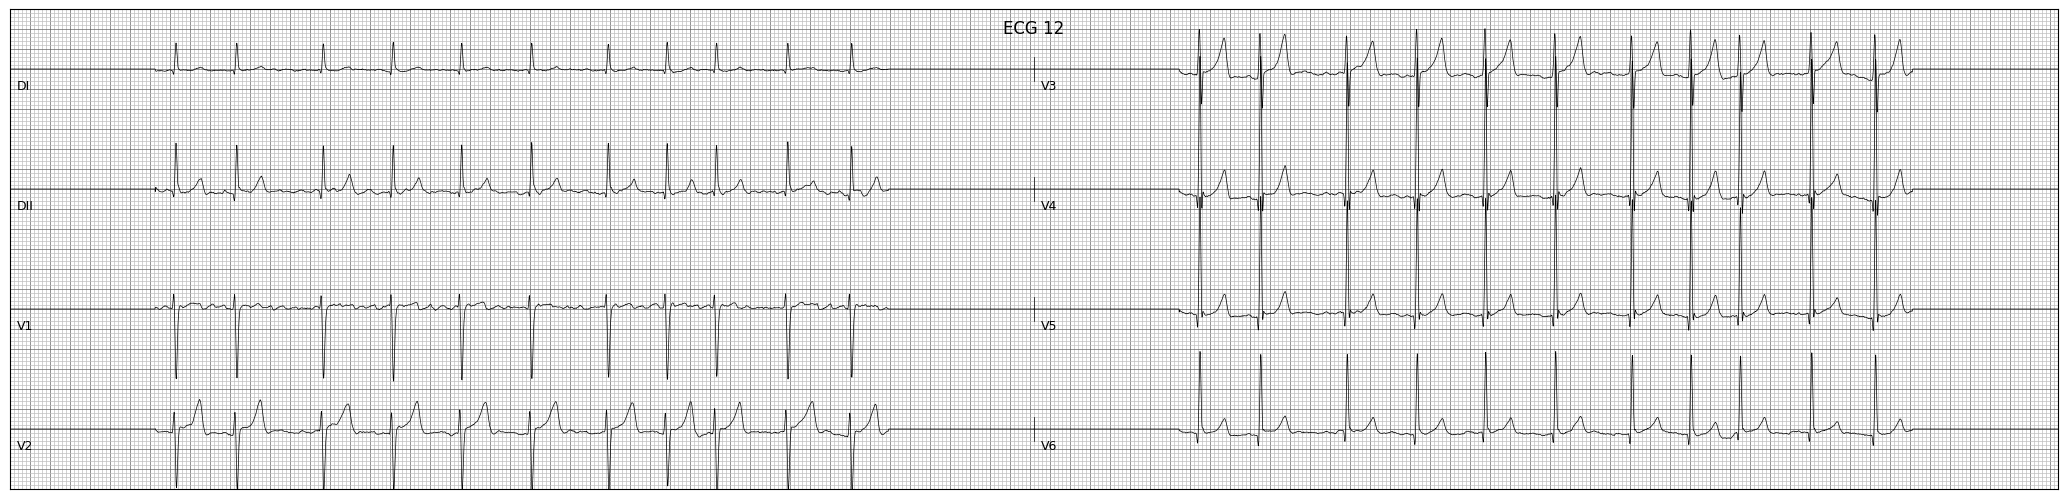

<Figure size 640x480 with 0 Axes>

In [8]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [8]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

codesubset/train.h5 already exits. Using cached. Delete it manually to recieve it again!
codesubset/test.h5 already exits. Using cached. Delete it manually to recieve it again!


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


In [ ]:
"""
TASK: Insert your code here
"""

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**

---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [10]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [30]:
!pip install imbalanced-learn

In [9]:
import torch
import torch.nn as nn
import math

# Helper class for Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Model(nn.Module):
    def __init__(self, num_leads=8, seq_len=4096, patch_size=32,
                 embed_dim=128, num_layers=6, num_heads=8,
                 dropout=0.1, mlp_dim=512):
        super(Model, self).__init__()

        # 1. Patching and Embedding Layer
        # This Conv1d acts as a patch extractor and embedder.
        # It reduces the sequence length from 4096 to 128 (4096 / 32).
        self.patch_embed = nn.Conv1d(num_leads, embed_dim,
                                     kernel_size=patch_size, stride=patch_size)

        # Calculate the number of patches
        num_patches = seq_len // patch_size

        # 2. Special [CLS] Token
        # This token will be prepended to the sequence of patches
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # 3. Positional Encoding
        # We add 1 to num_patches to account for the [CLS] token
        self.pos_encoder = PositionalEncoding(embed_dim, dropout, max_len=num_patches + 1)

        # 4. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=mlp_dim, dropout=dropout,
                                                   batch_first=True) # Important: batch_first=True
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 5. Classifier Head
        self.classifier_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 1)
        )

    def forward(self, x):
        # Input x shape: (batch_size, seq_len, num_leads) = (B, 4096, 8)

        # Transpose for Conv1d: (B, num_leads, seq_len) = (B, 8, 4096)
        x = x.transpose(1, 2)

        # Patching and Embedding: (B, embed_dim, num_patches)
        x = self.patch_embed(x)

        # Transpose for Transformer: (B, num_patches, embed_dim)
        x = x.transpose(1, 2)

        # Prepend [CLS] token: (B, num_patches + 1, embed_dim)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional encoding. Note: Pytorch's PE implementation is not batch_first
        # So we need to transpose, apply PE, and transpose back.
        x = x.transpose(0, 1) # (num_patches + 1, B, embed_dim)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1) # (B, num_patches + 1, embed_dim)

        # Pass through Transformer Encoder
        x = self.transformer_encoder(x)

        # Extract the output of the [CLS] token
        # This token has aggregated information from the entire sequence
        cls_output = x[:, 0]

        # Pass through the classifier head to get final logits
        logits = self.classifier_head(cls_output)

        return logits

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [10]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        # === Training step ===
        outputs = model(traces)
        loss = loss_function(outputs, diagnoses)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ======================

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [11]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_probs = []  # accumulated predicted probabilities
    valid_true = [] # accumulated true labels

    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        # === Evaluation step ===
        with torch.no_grad():
            outputs = model(traces)
            loss = loss_function(outputs, diagnoses)
            probs = torch.sigmoid(outputs)
            valid_probs.append(probs.detach().cpu().numpy())
            valid_true.append(diagnoses_cpu.numpy())
        # ========================

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_probs), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**


In [12]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-4
weight_decay = 1e-2
num_epochs = 100
batch_size = 128

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Load Original Data ======================================#
tqdm.write("Loading original data...")
path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
tqdm.write("Done!\n")

# =============== Split Data ==============================================#
tqdm.write("Splitting data into training and validation sets...")
# Split indices to ensure validation set represents the original distribution
train_indices, valid_indices = train_test_split(range(len(labels)), test_size=0.2, random_state=42, stratify=labels)

# Create the validation dataset using a subset of the original data
dataset_valid = torch.utils.data.Subset(TensorDataset(traces, labels), valid_indices)
tqdm.write("Done!\n")


# =============== Apply SMOTE to Training Data ============================#
tqdm.write("Applying SMOTE to the training set...")

# Get the original training data
X_train = traces[train_indices]
y_train = labels[train_indices]

# Reshape data for SMOTE (it expects 2D data)
# We flatten the last two dimensions (4096, 12) into one
n_samples_train, seq_len, n_leads = X_train.shape
X_train_reshaped = X_train.reshape(n_samples_train, -1).numpy()
y_train_np = y_train.numpy().ravel() # .ravel() to make it a 1D array

tqdm.write(f'Original training shape: {Counter(y_train_np)}')

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train_np)

tqdm.write(f'Resampled training shape: {Counter(y_train_resampled)}')


# Reshape the resampled data back to the original image format (samples, 4096, 12)
# and convert back to torch tensors
X_train_resampled = torch.tensor(X_train_resampled.reshape(-1, seq_len, n_leads), dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.float32).reshape(-1,1)
tqdm.write("Done!\n")

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

# Create a new TensorDataset for the resampled training data
dataset_train = TensorDataset(X_train_resampled, y_train_resampled)

# Build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

Use device: cuda

Loading original data...
Done!

Splitting data into training and validation sets...
Done!

Applying SMOTE to the training set...
Original training shape: Counter({0.0: 4900, 1.0: 2100})
Resampled training shape: Counter({1.0: 4900, 0.0: 4900})
Done!

Building data loaders...
Done!



In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score

# =============== Define model ============================================#
tqdm.write("Define model...")

# Use the stronger Transformer model
model = Model()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#

# Pass the weight to the loss function
loss_function = torch.nn.BCEWithLogitsLoss()

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
# AdamW is often a better choice for Transformer models
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# OPTIONAL: A scheduler like ReduceLROnPlateau works well with early stopping
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf

# --- Early Stopping Parameters ---
patience = 10  # Number of epochs to wait for improvement before stopping
patience_counter = 0
# -------------------------------

# allocation
train_loss_all, valid_loss_all = [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    y_pred_flat = y_pred.flatten()
    y_true_flat = y_true.flatten()
    auroc = roc_auc_score(y_true_flat, y_pred_flat)
    accuracy = accuracy_score(y_true_flat, np.round(y_pred_flat))

    tqdm.write(f"Epoch {epoch:2d} - AUROC: {auroc:.4f} - Accuracy: {accuracy:.2f}")

    # --- Early Stopping Logic ---
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
        # Reset patience counter
        patience_counter = 0
    else:
        model_save_state = ""
        # Increment patience counter
        patience_counter += 1

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        model_save=model_save_state)
                    )

    # Check if we should stop training
    if patience_counter >= patience:
        tqdm.write(f"\nEarly stopping triggered after {patience} epochs without improvement.")
        break # Exit the training loop
    # --------------------------

    # Update learning rate with lr-scheduler based on validation loss
    if lr_scheduler:
        lr_scheduler.step(valid_loss)

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""

Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/100 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch  1 - AUROC: 0.5798 - Accuracy: 0.30
Epoch  1: 	Train Loss 0.005508 	Valid Loss 0.005602 	Best model -> saved


Training Epoch  2:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch  2 - AUROC: 0.6296 - Accuracy: 0.64
Epoch  2: 	Train Loss 0.005418 	Valid Loss 0.005177 	Best model -> saved


Training Epoch  3:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch  3 - AUROC: 0.7504 - Accuracy: 0.69
Epoch  3: 	Train Loss 0.004471 	Valid Loss 0.004996 	Best model -> saved


Training Epoch  4:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch  4 - AUROC: 0.7993 - Accuracy: 0.76
Epoch  4: 	Train Loss 0.003948 	Valid Loss 0.004145 	Best model -> saved


Training Epoch  5:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch  5 - AUROC: 0.8313 - Accuracy: 0.76
Epoch  5: 	Train Loss 0.003614 	Valid Loss 0.004155 	


Training Epoch  6:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch  6 - AUROC: 0.8542 - Accuracy: 0.78
Epoch  6: 	Train Loss 0.003245 	Valid Loss 0.003769 	Best model -> saved


Training Epoch  7:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch  7 - AUROC: 0.8694 - Accuracy: 0.82
Epoch  7: 	Train Loss 0.003048 	Valid Loss 0.003383 	Best model -> saved


Training Epoch  8:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch  8 - AUROC: 0.8820 - Accuracy: 0.83
Epoch  8: 	Train Loss 0.002860 	Valid Loss 0.003254 	Best model -> saved


Training Epoch  9:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch  9 - AUROC: 0.8893 - Accuracy: 0.82
Epoch  9: 	Train Loss 0.002765 	Valid Loss 0.003331 	


Training Epoch 10:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10 - AUROC: 0.8947 - Accuracy: 0.83
Epoch 10: 	Train Loss 0.002682 	Valid Loss 0.003085 	Best model -> saved


Training Epoch 11:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11 - AUROC: 0.9031 - Accuracy: 0.84
Epoch 11: 	Train Loss 0.002524 	Valid Loss 0.002989 	Best model -> saved


Training Epoch 12:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12 - AUROC: 0.9095 - Accuracy: 0.84
Epoch 12: 	Train Loss 0.002450 	Valid Loss 0.002882 	Best model -> saved


Training Epoch 13:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13 - AUROC: 0.9176 - Accuracy: 0.84
Epoch 13: 	Train Loss 0.002312 	Valid Loss 0.002878 	Best model -> saved


Training Epoch 14:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14 - AUROC: 0.9188 - Accuracy: 0.85
Epoch 14: 	Train Loss 0.002284 	Valid Loss 0.002873 	Best model -> saved


Training Epoch 15:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15 - AUROC: 0.9218 - Accuracy: 0.86
Epoch 15: 	Train Loss 0.002152 	Valid Loss 0.002707 	Best model -> saved


Training Epoch 16:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16 - AUROC: 0.9300 - Accuracy: 0.86
Epoch 16: 	Train Loss 0.002093 	Valid Loss 0.002581 	Best model -> saved


Training Epoch 17:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17 - AUROC: 0.9340 - Accuracy: 0.87
Epoch 17: 	Train Loss 0.001988 	Valid Loss 0.002534 	Best model -> saved


Training Epoch 18:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18 - AUROC: 0.9271 - Accuracy: 0.85
Epoch 18: 	Train Loss 0.001921 	Valid Loss 0.002771 	


Training Epoch 19:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19 - AUROC: 0.9376 - Accuracy: 0.88
Epoch 19: 	Train Loss 0.001831 	Valid Loss 0.002486 	Best model -> saved


Training Epoch 20:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20 - AUROC: 0.9425 - Accuracy: 0.87
Epoch 20: 	Train Loss 0.001822 	Valid Loss 0.002448 	Best model -> saved


Training Epoch 21:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 21:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21 - AUROC: 0.9456 - Accuracy: 0.89
Epoch 21: 	Train Loss 0.001723 	Valid Loss 0.002347 	Best model -> saved


Training Epoch 22:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 22:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22 - AUROC: 0.9464 - Accuracy: 0.88
Epoch 22: 	Train Loss 0.001729 	Valid Loss 0.002286 	Best model -> saved


Training Epoch 23:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 23:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23 - AUROC: 0.9484 - Accuracy: 0.89
Epoch 23: 	Train Loss 0.001632 	Valid Loss 0.002311 	


Training Epoch 24:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 24:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24 - AUROC: 0.9486 - Accuracy: 0.88
Epoch 24: 	Train Loss 0.001605 	Valid Loss 0.002323 	


Training Epoch 25:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 25:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25 - AUROC: 0.9507 - Accuracy: 0.88
Epoch 25: 	Train Loss 0.001568 	Valid Loss 0.002392 	


Training Epoch 26:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 26:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26 - AUROC: 0.9483 - Accuracy: 0.88
Epoch 26: 	Train Loss 0.001487 	Valid Loss 0.002358 	


Training Epoch 27:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 27:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27 - AUROC: 0.9535 - Accuracy: 0.89
Epoch 27: 	Train Loss 0.001427 	Valid Loss 0.002326 	


Training Epoch 28:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 28:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28 - AUROC: 0.9531 - Accuracy: 0.89
Epoch 28: 	Train Loss 0.001492 	Valid Loss 0.002207 	Best model -> saved


Training Epoch 29:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 29:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29 - AUROC: 0.9502 - Accuracy: 0.89
Epoch 29: 	Train Loss 0.001404 	Valid Loss 0.002344 	


Training Epoch 30:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 30:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30 - AUROC: 0.9535 - Accuracy: 0.89
Epoch 30: 	Train Loss 0.001300 	Valid Loss 0.002321 	


Training Epoch 31:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 31:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31 - AUROC: 0.9549 - Accuracy: 0.89
Epoch 31: 	Train Loss 0.001257 	Valid Loss 0.002239 	


Training Epoch 32:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 32:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32 - AUROC: 0.9539 - Accuracy: 0.89
Epoch 32: 	Train Loss 0.001199 	Valid Loss 0.002383 	


Training Epoch 33:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 33:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33 - AUROC: 0.9576 - Accuracy: 0.90
Epoch 33: 	Train Loss 0.001248 	Valid Loss 0.002144 	Best model -> saved


Training Epoch 34:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 34:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34 - AUROC: 0.9556 - Accuracy: 0.89
Epoch 34: 	Train Loss 0.001171 	Valid Loss 0.002360 	


Training Epoch 35:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 35:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35 - AUROC: 0.9514 - Accuracy: 0.89
Epoch 35: 	Train Loss 0.001161 	Valid Loss 0.002327 	


Training Epoch 36:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 36:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36 - AUROC: 0.9572 - Accuracy: 0.89
Epoch 36: 	Train Loss 0.001090 	Valid Loss 0.002193 	


Training Epoch 37:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 37:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37 - AUROC: 0.9570 - Accuracy: 0.89
Epoch 37: 	Train Loss 0.001036 	Valid Loss 0.002350 	


Training Epoch 38:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 38:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38 - AUROC: 0.9565 - Accuracy: 0.88
Epoch 38: 	Train Loss 0.001030 	Valid Loss 0.002567 	


Training Epoch 39:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 39:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39 - AUROC: 0.9559 - Accuracy: 0.89
Epoch 39: 	Train Loss 0.001001 	Valid Loss 0.002513 	
Epoch 00039: reducing learning rate of group 0 to 1.0000e-05.


Training Epoch 40:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 40:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40 - AUROC: 0.9579 - Accuracy: 0.90
Epoch 40: 	Train Loss 0.000894 	Valid Loss 0.002336 	


Training Epoch 41:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 41:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41 - AUROC: 0.9583 - Accuracy: 0.90
Epoch 41: 	Train Loss 0.000837 	Valid Loss 0.002316 	


Training Epoch 42:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 42:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42 - AUROC: 0.9579 - Accuracy: 0.90
Epoch 42: 	Train Loss 0.000800 	Valid Loss 0.002371 	


Training Epoch 43:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluation Epoch 43:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43 - AUROC: 0.9585 - Accuracy: 0.89
Epoch 43: 	Train Loss 0.000805 	Valid Loss 0.002365 	

Early stopping triggered after 10 epochs without improvement.


'\nTASK: Here it can make sense to plot your learning curve; Insert your code here\n'

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

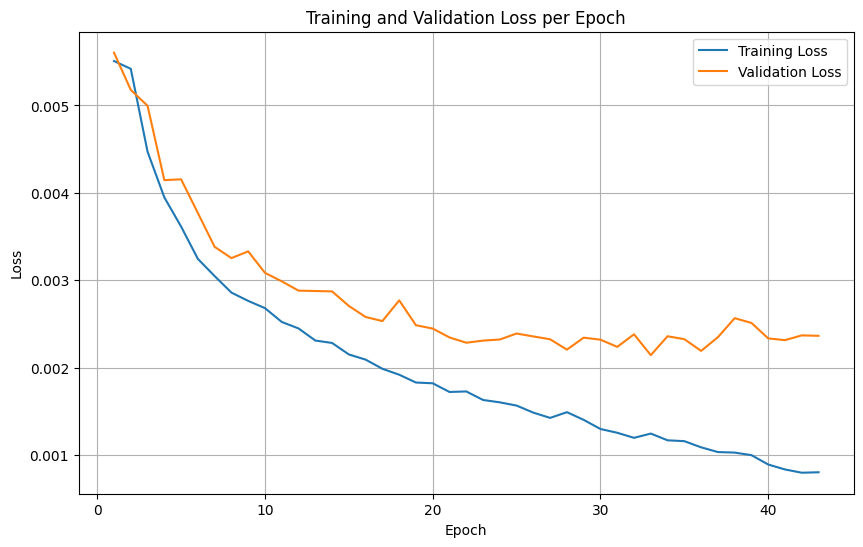

In [15]:
# prompt: plot the training

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_all) + 1), train_loss_all, label='Training Loss')
plt.plot(range(1, len(valid_loss_all) + 1), valid_loss_all, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain soft predictions (probabilities) instead of hard predictions (0s or 1s).

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The predictions are saved in the variable `soft_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [17]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [18]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()

# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [19]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

Cloning into 'leaderboard'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (3/3), done.


In [20]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password.
Do not change this after you have registered your team
"""
team_id = 'goat' #Fill in a string
password = 'waspasrs' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

Team registered successfully! Good luck


In [21]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = '1st try' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>Fill in</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**